In [2]:
%matplotlib inline

import pickle
from pathlib import Path
from random import sample

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.utils import resample

In [4]:
# Data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#mnist

def load_xy(folder, pbar=True):
    with (folder / 'data').open('r') as f:
        data = f.readlines()
    if pbar:
        data = tqdm(data)
    
    xs = np.zeros((len(data), 784), dtype=np.float32)
    ys = np.zeros(len(data), dtype=np.int32)
    for i, line in enumerate(data):
        ts = line.split()
        ys[i] = int(ts[0])
        for t in ts[1:]:
            idx = t.find(':')
            xs[i][int(t[:idx]) - 1] = int(t[idx + 1:]) / 255
    
    return xs, ys

data = Path('../../data/')
xt, yt = load_xy(data / 'mnist', pbar=True)
xv, yv = load_xy(data / 'mnist.t', pbar=True)

100%|██████████| 10000/10000 [00:02<00:00, 4338.06it/s]


In [5]:
%%time

pca = PCA(n_components=20)
pca.fit(xt)
xt, yt = pca.transform(xt), yt
xv, yv = pca.transform(xv), yv
print(pca.explained_variance_ratio_.cumsum())

[ 0.09704709  0.16800663  0.22969776  0.28359222  0.33228043  0.37540293
  0.40812236  0.43696147  0.46458194  0.48815209  0.50924408  0.52947408
  0.54663229  0.56355351  0.57933998  0.59416956  0.6074152   0.62018353
  0.63205373  0.6435805 ]
CPU times: user 7.39 s, sys: 4.12 s, total: 11.5 s
Wall time: 3.56 s


In [7]:
%%time

params = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [1e-2, 1e-1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 1e-1, 1, 10],    
},

xs, ys = resample(xt, yt, n_samples=10000)
clf = GridSearchCV(SVC(), params, cv=2, scoring='accuracy', 
                   n_jobs=2, return_train_score=True)
clf.fit(xs, ys)
print('Best Param:', clf.best_params_)
print('Best Model Score:', clf.best_estimator_.score(xv, yv))

with open('gridcv.pkl', 'wb') as f:
    pickle.dump(clf, f)

Best Param: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Model Score: 0.9671
CPU times: user 10.4 s, sys: 125 ms, total: 10.6 s
Wall time: 6min 54s


In [6]:
with open('gridcv.pkl', 'rb') as f:
    clf = pickle.load(f)
    
data = pd.DataFrame(clf.cv_results_)
data.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,param_kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.745880,2.455050,0.1142,0.114200,0.01,0.001,rbf,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",67,0.114154,0.114246,0.114246,0.114154,0.132091,0.017029,0.000046,0.000046
1,0.507368,0.604691,0.8879,0.894001,0.01,0.001,linear,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}",48,0.885446,0.895958,0.890356,0.892043,0.006479,0.009040,0.002455,0.001958
2,2.764589,1.424498,0.1142,0.114200,0.01,0.001,poly,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'poly'}",67,0.114154,0.114246,0.114246,0.114154,0.014036,0.002035,0.000046,0.000046
3,4.540175,2.426104,0.6588,0.661402,0.01,0.01,rbf,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",56,0.650540,0.667267,0.667067,0.655538,0.023468,0.014698,0.008264,0.005865
4,0.509910,0.610820,0.8879,0.894001,0.01,0.01,linear,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}",48,0.885446,0.895958,0.890356,0.892043,0.007363,0.009868,0.002455,0.001958


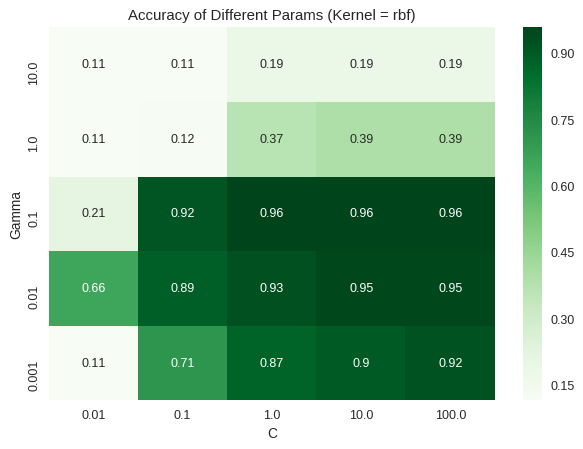

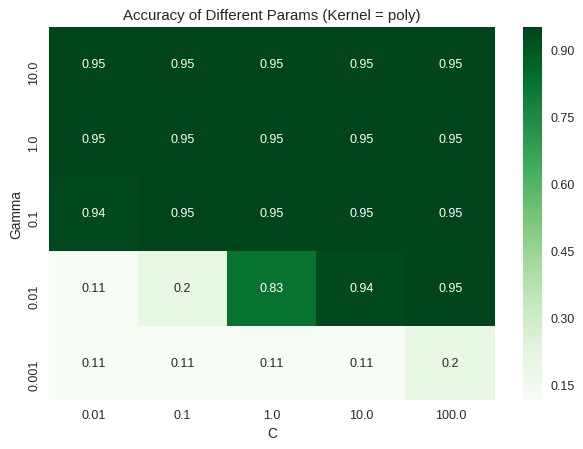

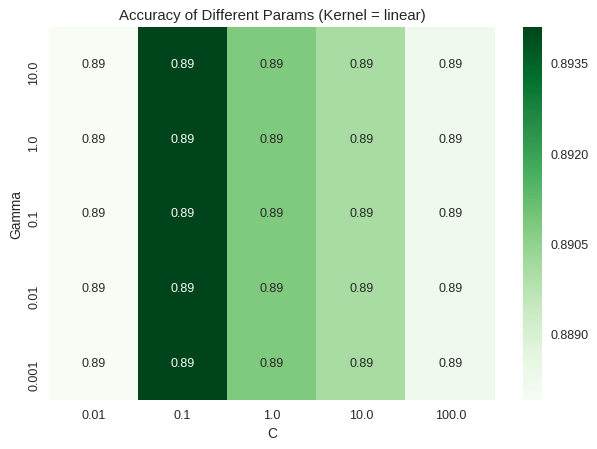

In [11]:
for k in ['rbf', 'poly', 'linear']:
    df = data[data['param_kernel'] == k]
    df = df.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

    fig, ax = plt.subplots(dpi=90)
    sns.heatmap(df, ax=ax, annot=True, cmap=plt.cm.Greens)
    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_title('Accuracy of Different Params (Kernel = {})'.format(k))
    ax.invert_yaxis()
    fig.savefig(f'svm_{k}.png')
    plt.show()

In [1]:
def plot2d(xs, ys, ax):
    cmap = plt.cm.tab10_r
    for y in range(10):
        data = xs[ys == y, :]
        ax[y].scatter(data[:, 0], data[:, 1], c=cmap(y / 10), label=y, edgecolors='k')
    return ax

In [7]:
%%time
rf = RandomForestClassifier(n_estimators=20)
rf.fit(xt, yt)
rf_pred = rf.predict(xv)
rf_acc = rf.score(xv, yv)
print(classification_report(yv, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.98      0.99      0.99      1135
          2       0.93      0.93      0.93      1032
          3       0.91      0.94      0.93      1010
          4       0.91      0.93      0.92       982
          5       0.93      0.91      0.92       892
          6       0.95      0.97      0.96       958
          7       0.96      0.93      0.95      1028
          8       0.92      0.90      0.91       974
          9       0.92      0.91      0.91      1009

avg / total       0.94      0.94      0.94     10000

CPU times: user 7.86 s, sys: 0 ns, total: 7.86 s
Wall time: 7.89 s


In [8]:
%%time
svm = clf.best_estimator_
svm_pred = svm.predict(xv)
svm_acc = svm.score(xv, yv)
print(classification_report(yv, svm_pred))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.95      0.97      0.96      1032
          3       0.96      0.96      0.96      1010
          4       0.97      0.97      0.97       982
          5       0.96      0.96      0.96       892
          6       0.99      0.97      0.98       958
          7       0.96      0.95      0.96      1028
          8       0.96      0.95      0.96       974
          9       0.96      0.95      0.95      1009

avg / total       0.97      0.97      0.97     10000

CPU times: user 6.85 s, sys: 524 µs, total: 6.85 s
Wall time: 6.88 s


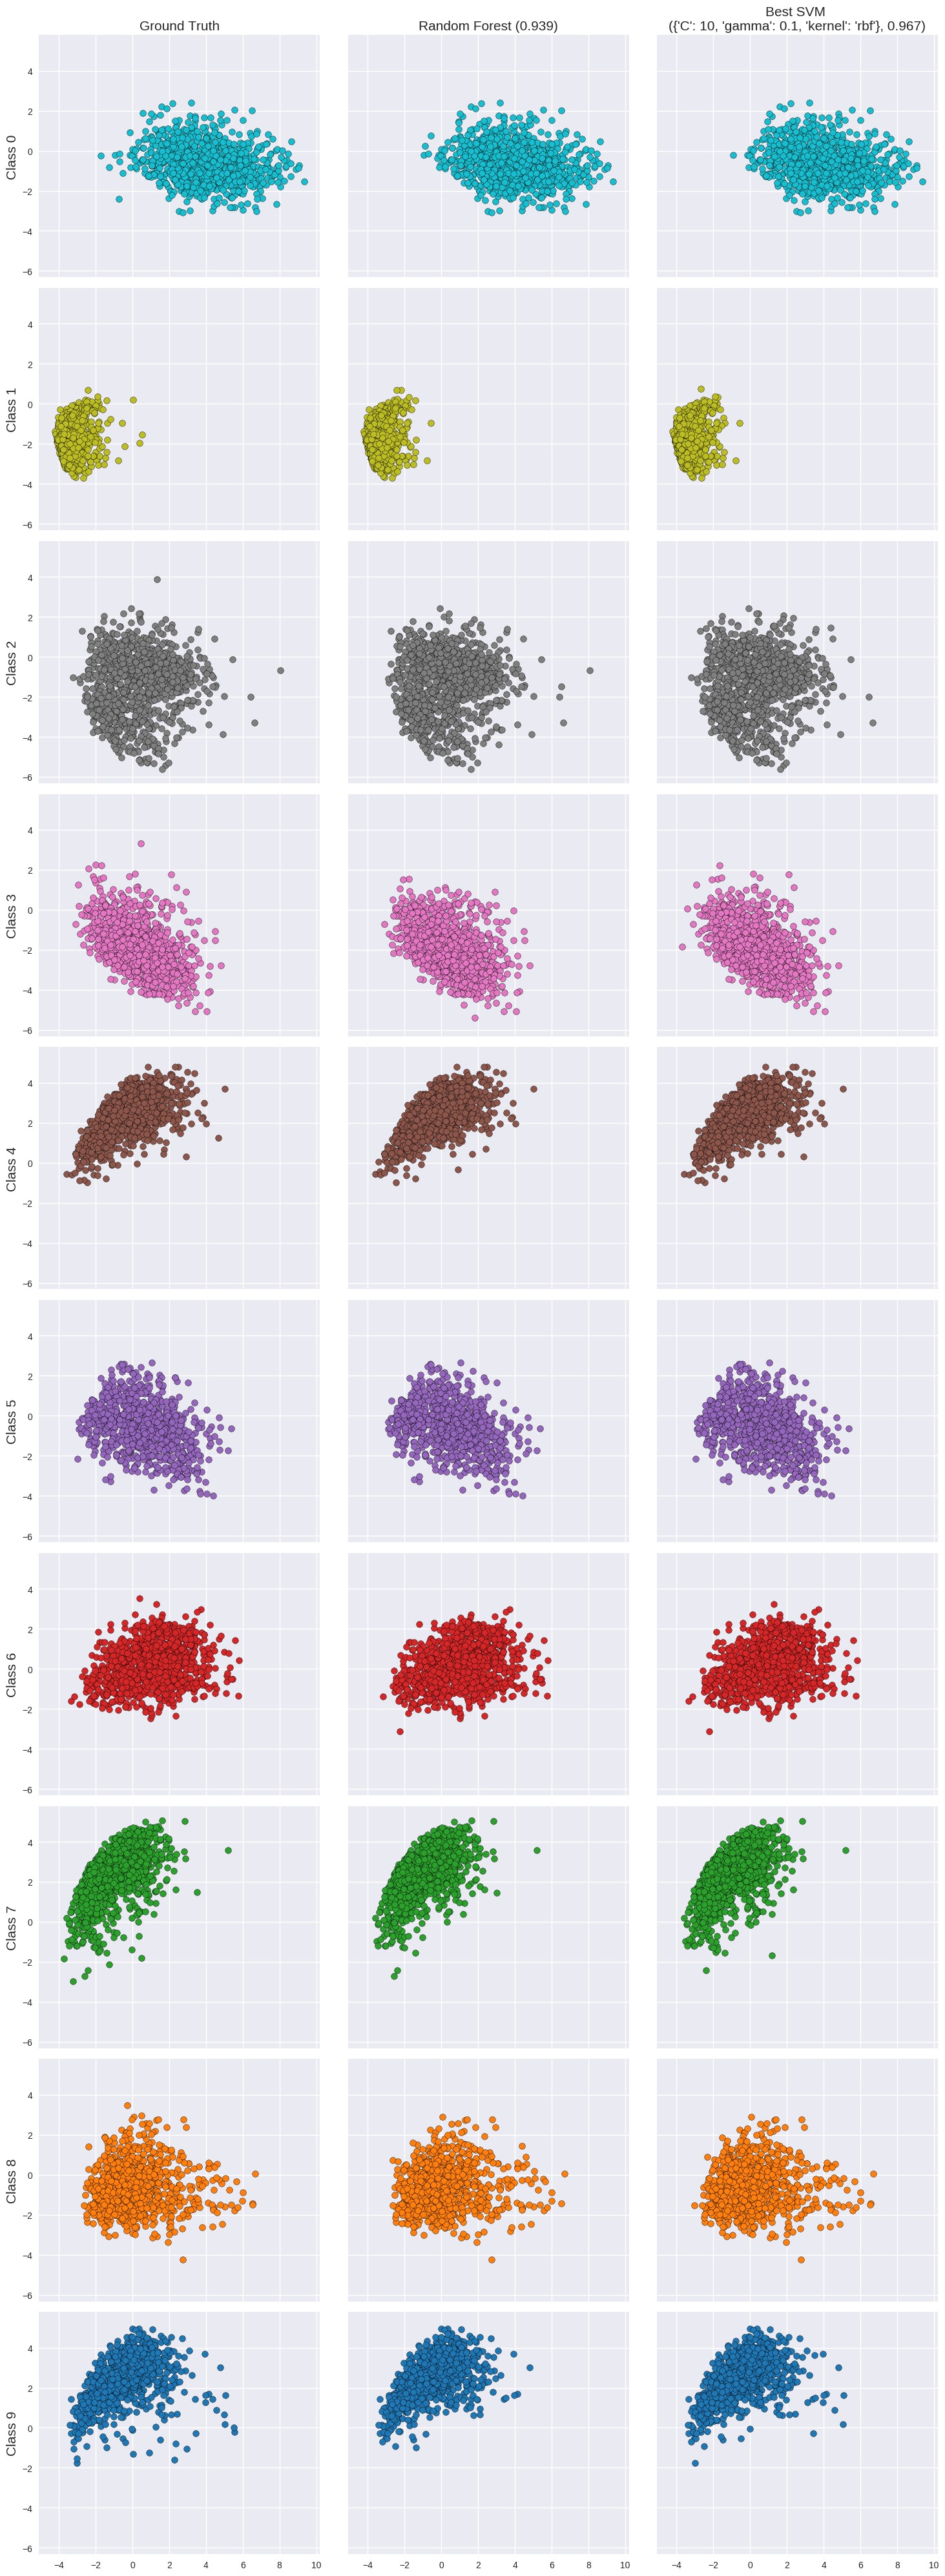

In [9]:
fig, ax = plt.subplots(10, 3, sharex=True, sharey=True, dpi=100, figsize=(15, 40))
plot2d(xv, yv, ax[:, 0])
plot2d(xv, rf_pred, ax[:, 1])
plot2d(xv, svm_pred, ax[:, 2])

col_headers = [f'Class {x}' for x in range(10)]
row_headers = [
    'Ground Truth', 
    f'Random Forest ({rf_acc:.3f})', 
    f'Best SVM \n({clf.best_params_}, {svm_acc:.3f})'
]
for i, rh in enumerate(row_headers):
    ax[0, i].set_title(rh, fontsize=15)
for i, ch in enumerate(col_headers):
    ax[i, 0].set_ylabel(ch, fontsize=15)
    
fig.tight_layout()
fig.savefig('plot.png')
plt.show()

## Difficulties

### SVM(rbf) diverse

### TSNE

### UnderFitting